#### Thanks to:
- Amira Adel Foda (intake 42 - smart village branch - group 2)
- Asmaa Said (intake 42 - smart village branch - group 2)
- Marawan Mohamed (intake 42 - Alex. branch - group 2)


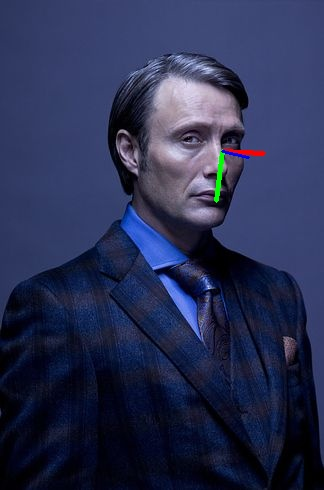

### Importing Libraries

In [1]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')

### Helper Functions

In [2]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Extracting Features From Dataset Using Mediapipe

In [7]:
X = []
Y = []
mediapipe_files = []

path = 'dataset\\AFLW2000-3D\\AFLW2000\\'

faceModule = mediapipe.solutions.face_mesh

with faceModule.FaceMesh(static_image_mode=True) as faces:
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            image = cv2.imread(path + filename)
            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
                image_x = []
                image_y = []
                X.append(image_x)
                Y.append(image_y)
                mediapipe_files.append(filename)
                for face in results.multi_face_landmarks:
                    for landmark in face.landmark:
                        x = landmark.x
                        y = landmark.y
                        shape = image.shape 
                        relative_x = int(x * shape[1])
                        relative_y = int(y * shape[0])
                        image_x.append(relative_x)
                        image_y.append(relative_y)

### Collecting Labels From Dataset

In [8]:
pitch_col = []
yaw_col = []
roll_col = []

path = 'dataset\\AFLW2000-3D\\AFLW2000\\'

for filename in mediapipe_files:
    mat_file = sio.loadmat(path+filename.replace('.jpg', '')+'.mat')
    pose_para = mat_file["Pose_Para"][0][:3]
    pitch_col.append(pose_para[0])
    yaw_col.append(pose_para[1])
    roll_col.append(pose_para[2])

In [9]:
labels = pd.DataFrame(data = {'pitch' : pitch_col, 'yaw' : yaw_col, 'roll' : roll_col})

In [10]:
labels

,pitch,yaw,roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959
2,-0.184650,0.881137,-0.236852
3,-0.175379,0.299208,-0.373374
4,-0.026812,0.011965,-0.220662
...,...,...,...
1848,-0.306358,-0.283822,0.038554
1849,-0.367547,-0.429723,0.122791
1850,-0.156035,0.567114,-0.108536
1851,-0.197102,-0.070430,0.105118


### Creating Features Dataframe

In [11]:
df2 = pd.DataFrame(data = list(X[0]))
df2 = df2.T
df2

,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
0,218,220,220,215,220,222,226,163,228,229,...,229,234,243,227,226,251,246,243,299,304


In [12]:
for i in range(1, 1853):
    df_x = pd.DataFrame(data = list(X[i]))
    df_x = df_x.T
    df2 = pd.concat([df2, df_x], axis=0,  ignore_index=True)

In [13]:
df2

,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
0,218,220,220,215,220,222,226,163,228,229,...,229,234,243,227,226,251,246,243,299,304
1,198,187,201,196,187,192,208,208,213,212,...,198,200,216,196,200,235,230,225,263,267
2,143,144,143,139,144,144,142,111,141,141,...,147,149,152,147,146,150,148,147,168,169
3,226,211,220,199,207,205,203,162,196,192,...,222,225,239,221,222,228,223,220,268,271
4,229,221,224,210,219,217,213,161,210,208,...,230,233,243,229,228,234,229,227,271,275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,231,239,233,230,240,239,234,162,233,234,...,244,248,250,243,240,247,243,243,283,286
1849,244,254,247,245,255,255,250,179,250,251,...,258,263,264,257,255,261,259,258,296,300
1850,263,271,267,271,274,276,281,228,286,290,...,277,281,286,275,274,298,294,292,330,334
1851,221,225,223,220,226,227,231,159,233,234,...,233,239,246,232,230,256,250,247,303,308


### Face Alignment (Centring & Scaling Faces)

In [14]:
for index, row in df2.iterrows():
    df2.iloc[index] = (df2.iloc[index] - row[99]) / (np.linalg.norm(row[400] - row[200]))

In [15]:
df2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 468 columns):
 #    Column  Non-Null Count  Dtype  
---   ------  --------------  -----  
 0    0       1851 non-null   float64
 1    1       1853 non-null   float64
 2    2       1853 non-null   float64
 3    3       1853 non-null   float64
 4    4       1853 non-null   float64
 5    5       1853 non-null   float64
 6    6       1853 non-null   float64
 7    7       1853 non-null   float64
 8    8       1853 non-null   float64
 9    9       1852 non-null   float64
 10   10      1853 non-null   float64
 11   11      1852 non-null   float64
 12   12      1852 non-null   float64
 13   13      1851 non-null   float64
 14   14      1851 non-null   float64
 15   15      1849 non-null   float64
 16   16      1849 non-null   float64
 17   17      1853 non-null   float64
 18   18      1851 non-null   float64
 19   19      1853 non-null   float64
 20   20      1853 non-null   float64
 21   21      1853

In [16]:
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2.fillna(0, inplace=True)
df2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 468 columns):
 #    Column  Non-Null Count  Dtype  
---   ------  --------------  -----  
 0    0       1853 non-null   float64
 1    1       1853 non-null   float64
 2    2       1853 non-null   float64
 3    3       1853 non-null   float64
 4    4       1853 non-null   float64
 5    5       1853 non-null   float64
 6    6       1853 non-null   float64
 7    7       1853 non-null   float64
 8    8       1853 non-null   float64
 9    9       1853 non-null   float64
 10   10      1853 non-null   float64
 11   11      1853 non-null   float64
 12   12      1853 non-null   float64
 13   13      1853 non-null   float64
 14   14      1853 non-null   float64
 15   15      1853 non-null   float64
 16   16      1853 non-null   float64
 17   17      1853 non-null   float64
 18   18      1853 non-null   float64
 19   19      1853 non-null   float64
 20   20      1853 non-null   float64
 21   21      1853

In [17]:
df2

,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
0,0.294118,0.352941,0.352941,0.205882,0.352941,0.411765,0.529412,-1.323529,0.588235,0.617647,...,0.617647,0.764706,1.029412,0.558824,0.529412,1.264706,1.117647,1.029412,2.676471,2.823529
1,0.000000,-0.333333,0.090909,-0.060606,-0.333333,-0.181818,0.303030,0.303030,0.454545,0.424242,...,0.000000,0.060606,0.545455,-0.060606,0.060606,1.121212,0.969697,0.818182,1.969697,2.090909
2,0.428571,0.500000,0.428571,0.142857,0.500000,0.500000,0.357143,-1.857143,0.285714,0.285714,...,0.714286,0.857143,1.071429,0.714286,0.642857,0.928571,0.785714,0.714286,2.214286,2.285714
3,0.363636,0.022727,0.227273,-0.250000,-0.068182,-0.113636,-0.159091,-1.090909,-0.318182,-0.409091,...,0.272727,0.340909,0.659091,0.250000,0.272727,0.409091,0.295455,0.227273,1.318182,1.386364
4,0.394737,0.184211,0.263158,-0.105263,0.131579,0.078947,-0.026316,-1.394737,-0.105263,-0.157895,...,0.421053,0.500000,0.763158,0.394737,0.368421,0.526316,0.394737,0.342105,1.500000,1.605263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.473684,0.894737,0.578947,0.421053,0.947368,0.894737,0.631579,-3.157895,0.578947,0.631579,...,1.157895,1.368421,1.473684,1.105263,0.947368,1.315789,1.105263,1.105263,3.210526,3.368421
1849,0.526316,1.052632,0.684211,0.578947,1.105263,1.105263,0.842105,-2.894737,0.842105,0.894737,...,1.263158,1.526316,1.578947,1.210526,1.105263,1.421053,1.315789,1.263158,3.263158,3.473684
1850,0.300000,0.700000,0.500000,0.700000,0.850000,0.950000,1.200000,-1.450000,1.450000,1.650000,...,1.000000,1.200000,1.450000,0.900000,0.850000,2.050000,1.850000,1.750000,3.650000,3.850000
1851,0.344828,0.482759,0.413793,0.310345,0.517241,0.551724,0.689655,-1.793103,0.758621,0.793103,...,0.758621,0.965517,1.206897,0.724138,0.655172,1.551724,1.344828,1.241379,3.172414,3.344828


In [18]:
df3 = pd.DataFrame(data = list(Y[0]))
df3 = df3.T
df3

,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
0,309,287,291,253,279,265,228,203,201,189,...,288,285,286,289,290,218,221,225,212,208


In [19]:
for i in range(1, 1853):
    df_y = pd.DataFrame(data = list(Y[i]))
    df_y = df_y.T
    df3 = pd.concat([df3, df_y], axis=0,  ignore_index=True)

In [20]:
df3

,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
0,309,287,291,253,279,265,228,203,201,189,...,288,285,286,289,290,218,221,225,212,208
1,288,266,274,245,259,251,230,225,214,206,...,269,268,274,270,272,228,230,231,225,222
2,359,349,351,335,345,339,325,323,316,311,...,349,348,348,350,350,323,324,325,320,319
3,312,294,296,265,286,274,241,243,217,206,...,291,287,284,293,293,225,229,233,205,200
4,301,272,281,244,263,251,222,231,205,195,...,273,269,273,274,276,216,219,221,203,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,307,281,287,252,273,261,230,221,207,195,...,282,279,282,283,284,223,226,228,215,213
1849,310,285,291,253,277,264,229,215,203,190,...,286,283,285,288,288,221,225,227,215,211
1850,306,282,290,255,274,264,239,221,219,209,...,287,285,291,287,289,241,242,243,246,243
1851,311,286,292,251,277,263,227,207,200,186,...,288,286,288,289,290,220,223,226,216,213


In [21]:
for index, row in df3.iterrows():
    df3.iloc[index] = (df3.iloc[index] - row[99]) / (np.linalg.norm(row[400] - row[200]))

In [22]:
df3

,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
0,2.300000,0.100000,0.500000,-3.300000,-0.700000,-2.100000,-5.800000,-8.300000,-8.500000,-9.700000,...,0.200000,-0.100000,0.000000,0.300000,0.400000,-6.800000,-6.500000,-6.100000,-7.400000,-7.800000
1,0.761905,-0.285714,0.095238,-1.285714,-0.619048,-1.000000,-2.000000,-2.238095,-2.761905,-3.142857,...,-0.142857,-0.190476,0.095238,-0.095238,0.000000,-2.095238,-2.000000,-1.952381,-2.238095,-2.380952
2,1.285714,-0.142857,0.142857,-2.142857,-0.714286,-1.571429,-3.571429,-3.857143,-4.857143,-5.571429,...,-0.142857,-0.285714,-0.285714,0.000000,0.000000,-3.857143,-3.714286,-3.571429,-4.285714,-4.428571
3,5.333333,-0.666667,0.000000,-10.333333,-3.333333,-7.333333,-18.333333,-17.666667,-26.333333,-30.000000,...,-1.666667,-3.000000,-4.000000,-1.000000,-1.000000,-23.666667,-22.333333,-21.000000,-30.333333,-32.000000
4,1.235294,-0.470588,0.058824,-2.117647,-1.000000,-1.705882,-3.411765,-2.882353,-4.411765,-5.000000,...,-0.411765,-0.647059,-0.411765,-0.352941,-0.235294,-3.764706,-3.588235,-3.470588,-4.529412,-4.647059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,1.833333,-0.333333,0.166667,-2.750000,-1.000000,-2.000000,-4.583333,-5.333333,-6.500000,-7.500000,...,-0.250000,-0.500000,-0.250000,-0.166667,-0.083333,-5.166667,-4.916667,-4.750000,-5.833333,-6.000000
1849,2.200000,-0.300000,0.300000,-3.500000,-1.100000,-2.400000,-5.900000,-7.300000,-8.500000,-9.800000,...,-0.200000,-0.500000,-0.300000,0.000000,0.000000,-6.700000,-6.300000,-6.100000,-7.300000,-7.700000
1850,0.769231,-0.153846,0.153846,-1.192308,-0.461538,-0.846154,-1.807692,-2.500000,-2.576923,-2.961538,...,0.038462,-0.038462,0.192308,0.038462,0.115385,-1.730769,-1.692308,-1.653846,-1.538462,-1.653846
1851,1.437500,-0.125000,0.250000,-2.312500,-0.687500,-1.562500,-3.812500,-5.062500,-5.500000,-6.375000,...,0.000000,-0.125000,0.000000,0.062500,0.125000,-4.250000,-4.062500,-3.875000,-4.500000,-4.687500


In [23]:
df3.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 468 columns):
 #    Column  Non-Null Count  Dtype  
---   ------  --------------  -----  
 0    0       1853 non-null   float64
 1    1       1853 non-null   float64
 2    2       1853 non-null   float64
 3    3       1853 non-null   float64
 4    4       1853 non-null   float64
 5    5       1853 non-null   float64
 6    6       1853 non-null   float64
 7    7       1853 non-null   float64
 8    8       1853 non-null   float64
 9    9       1853 non-null   float64
 10   10      1853 non-null   float64
 11   11      1853 non-null   float64
 12   12      1853 non-null   float64
 13   13      1853 non-null   float64
 14   14      1853 non-null   float64
 15   15      1853 non-null   float64
 16   16      1853 non-null   float64
 17   17      1853 non-null   float64
 18   18      1853 non-null   float64
 19   19      1852 non-null   float64
 20   20      1852 non-null   float64
 21   21      1853

In [24]:
df3.replace([np.inf, -np.inf], np.nan, inplace=True)
df3.fillna(0, inplace=True)
df3.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 468 columns):
 #    Column  Non-Null Count  Dtype  
---   ------  --------------  -----  
 0    0       1853 non-null   float64
 1    1       1853 non-null   float64
 2    2       1853 non-null   float64
 3    3       1853 non-null   float64
 4    4       1853 non-null   float64
 5    5       1853 non-null   float64
 6    6       1853 non-null   float64
 7    7       1853 non-null   float64
 8    8       1853 non-null   float64
 9    9       1853 non-null   float64
 10   10      1853 non-null   float64
 11   11      1853 non-null   float64
 12   12      1853 non-null   float64
 13   13      1853 non-null   float64
 14   14      1853 non-null   float64
 15   15      1853 non-null   float64
 16   16      1853 non-null   float64
 17   17      1853 non-null   float64
 18   18      1853 non-null   float64
 19   19      1853 non-null   float64
 20   20      1853 non-null   float64
 21   21      1853

In [25]:
features = pd.concat([df2, df3], axis=1, ignore_index=True)
features

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,0.294118,0.352941,0.352941,0.205882,0.352941,0.411765,0.529412,-1.323529,0.588235,0.617647,...,0.200000,-0.100000,0.000000,0.300000,0.400000,-6.800000,-6.500000,-6.100000,-7.400000,-7.800000
1,0.000000,-0.333333,0.090909,-0.060606,-0.333333,-0.181818,0.303030,0.303030,0.454545,0.424242,...,-0.142857,-0.190476,0.095238,-0.095238,0.000000,-2.095238,-2.000000,-1.952381,-2.238095,-2.380952
2,0.428571,0.500000,0.428571,0.142857,0.500000,0.500000,0.357143,-1.857143,0.285714,0.285714,...,-0.142857,-0.285714,-0.285714,0.000000,0.000000,-3.857143,-3.714286,-3.571429,-4.285714,-4.428571
3,0.363636,0.022727,0.227273,-0.250000,-0.068182,-0.113636,-0.159091,-1.090909,-0.318182,-0.409091,...,-1.666667,-3.000000,-4.000000,-1.000000,-1.000000,-23.666667,-22.333333,-21.000000,-30.333333,-32.000000
4,0.394737,0.184211,0.263158,-0.105263,0.131579,0.078947,-0.026316,-1.394737,-0.105263,-0.157895,...,-0.411765,-0.647059,-0.411765,-0.352941,-0.235294,-3.764706,-3.588235,-3.470588,-4.529412,-4.647059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.473684,0.894737,0.578947,0.421053,0.947368,0.894737,0.631579,-3.157895,0.578947,0.631579,...,-0.250000,-0.500000,-0.250000,-0.166667,-0.083333,-5.166667,-4.916667,-4.750000,-5.833333,-6.000000
1849,0.526316,1.052632,0.684211,0.578947,1.105263,1.105263,0.842105,-2.894737,0.842105,0.894737,...,-0.200000,-0.500000,-0.300000,0.000000,0.000000,-6.700000,-6.300000,-6.100000,-7.300000,-7.700000
1850,0.300000,0.700000,0.500000,0.700000,0.850000,0.950000,1.200000,-1.450000,1.450000,1.650000,...,0.038462,-0.038462,0.192308,0.038462,0.115385,-1.730769,-1.692308,-1.653846,-1.538462,-1.653846
1851,0.344828,0.482759,0.413793,0.310345,0.517241,0.551724,0.689655,-1.793103,0.758621,0.793103,...,0.000000,-0.125000,0.000000,0.062500,0.125000,-4.250000,-4.062500,-3.875000,-4.500000,-4.687500


In [26]:
col_x = [('X_'+str(i+1)) for i in range (468)]
col_y = [('Y_'+str(i+1)) for i in range (468)]

In [27]:
features.columns = col_x + col_y

In [28]:
features

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,Y_459,Y_460,Y_461,Y_462,Y_463,Y_464,Y_465,Y_466,Y_467,Y_468
0,0.294118,0.352941,0.352941,0.205882,0.352941,0.411765,0.529412,-1.323529,0.588235,0.617647,...,0.200000,-0.100000,0.000000,0.300000,0.400000,-6.800000,-6.500000,-6.100000,-7.400000,-7.800000
1,0.000000,-0.333333,0.090909,-0.060606,-0.333333,-0.181818,0.303030,0.303030,0.454545,0.424242,...,-0.142857,-0.190476,0.095238,-0.095238,0.000000,-2.095238,-2.000000,-1.952381,-2.238095,-2.380952
2,0.428571,0.500000,0.428571,0.142857,0.500000,0.500000,0.357143,-1.857143,0.285714,0.285714,...,-0.142857,-0.285714,-0.285714,0.000000,0.000000,-3.857143,-3.714286,-3.571429,-4.285714,-4.428571
3,0.363636,0.022727,0.227273,-0.250000,-0.068182,-0.113636,-0.159091,-1.090909,-0.318182,-0.409091,...,-1.666667,-3.000000,-4.000000,-1.000000,-1.000000,-23.666667,-22.333333,-21.000000,-30.333333,-32.000000
4,0.394737,0.184211,0.263158,-0.105263,0.131579,0.078947,-0.026316,-1.394737,-0.105263,-0.157895,...,-0.411765,-0.647059,-0.411765,-0.352941,-0.235294,-3.764706,-3.588235,-3.470588,-4.529412,-4.647059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.473684,0.894737,0.578947,0.421053,0.947368,0.894737,0.631579,-3.157895,0.578947,0.631579,...,-0.250000,-0.500000,-0.250000,-0.166667,-0.083333,-5.166667,-4.916667,-4.750000,-5.833333,-6.000000
1849,0.526316,1.052632,0.684211,0.578947,1.105263,1.105263,0.842105,-2.894737,0.842105,0.894737,...,-0.200000,-0.500000,-0.300000,0.000000,0.000000,-6.700000,-6.300000,-6.100000,-7.300000,-7.700000
1850,0.300000,0.700000,0.500000,0.700000,0.850000,0.950000,1.200000,-1.450000,1.450000,1.650000,...,0.038462,-0.038462,0.192308,0.038462,0.115385,-1.730769,-1.692308,-1.653846,-1.538462,-1.653846
1851,0.344828,0.482759,0.413793,0.310345,0.517241,0.551724,0.689655,-1.793103,0.758621,0.793103,...,0.000000,-0.125000,0.000000,0.062500,0.125000,-4.250000,-4.062500,-3.875000,-4.500000,-4.687500


### The New Training Set After Using Mediapipe

In [29]:
Data = pd.concat([features, labels], axis=1)
Data

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,Y_462,Y_463,Y_464,Y_465,Y_466,Y_467,Y_468,pitch,yaw,roll
0,0.294118,0.352941,0.352941,0.205882,0.352941,0.411765,0.529412,-1.323529,0.588235,0.617647,...,0.300000,0.400000,-6.800000,-6.500000,-6.100000,-7.400000,-7.800000,-0.399231,0.018227,0.085676
1,0.000000,-0.333333,0.090909,-0.060606,-0.333333,-0.181818,0.303030,0.303030,0.454545,0.424242,...,-0.095238,0.000000,-2.095238,-2.000000,-1.952381,-2.238095,-2.380952,0.470065,1.189533,0.300959
2,0.428571,0.500000,0.428571,0.142857,0.500000,0.500000,0.357143,-1.857143,0.285714,0.285714,...,0.000000,0.000000,-3.857143,-3.714286,-3.571429,-4.285714,-4.428571,-0.184650,0.881137,-0.236852
3,0.363636,0.022727,0.227273,-0.250000,-0.068182,-0.113636,-0.159091,-1.090909,-0.318182,-0.409091,...,-1.000000,-1.000000,-23.666667,-22.333333,-21.000000,-30.333333,-32.000000,-0.175379,0.299208,-0.373374
4,0.394737,0.184211,0.263158,-0.105263,0.131579,0.078947,-0.026316,-1.394737,-0.105263,-0.157895,...,-0.352941,-0.235294,-3.764706,-3.588235,-3.470588,-4.529412,-4.647059,-0.026812,0.011965,-0.220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.473684,0.894737,0.578947,0.421053,0.947368,0.894737,0.631579,-3.157895,0.578947,0.631579,...,-0.166667,-0.083333,-5.166667,-4.916667,-4.750000,-5.833333,-6.000000,-0.306358,-0.283822,0.038554
1849,0.526316,1.052632,0.684211,0.578947,1.105263,1.105263,0.842105,-2.894737,0.842105,0.894737,...,0.000000,0.000000,-6.700000,-6.300000,-6.100000,-7.300000,-7.700000,-0.367547,-0.429723,0.122791
1850,0.300000,0.700000,0.500000,0.700000,0.850000,0.950000,1.200000,-1.450000,1.450000,1.650000,...,0.038462,0.115385,-1.730769,-1.692308,-1.653846,-1.538462,-1.653846,-0.156035,0.567114,-0.108536
1851,0.344828,0.482759,0.413793,0.310345,0.517241,0.551724,0.689655,-1.793103,0.758621,0.793103,...,0.062500,0.125000,-4.250000,-4.062500,-3.875000,-4.500000,-4.687500,-0.197102,-0.070430,0.105118


### Splitting Data into Train & Test

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

### yaw_model

In [31]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=150, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=1)
xgb.fit(X_train, y_train['yaw'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [32]:
from sklearn.metrics import mean_absolute_error

pred_train = xgb.predict(X_train)
print("Train MAE :", mean_absolute_error(y_train['yaw'], pred_train))

pred_test = xgb.predict(X_test)
print("Test MAE :", mean_absolute_error(y_test['yaw'], pred_test))

Train MAE : 0.026869560751647613
Test MAE : 0.07987698648575846


### pitch_model

In [33]:
xgb = XGBRegressor(n_estimators=100, max_depth=10, eta=0.1, subsample=1, colsample_bytree=1)
xgb.fit(X_train, y_train['pitch'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [34]:
pred_train = xgb.predict(X_train)
print("Train MAE :", mean_absolute_error(y_train['pitch'], pred_train))

pred_test = xgb.predict(X_test)
print("Test MAE :", mean_absolute_error(y_test['pitch'], pred_test))

Train MAE : 0.008558234645227194
Test MAE : 0.09400009563333302



### roll_model

In [35]:
xgb = XGBRegressor(n_estimators=150, max_depth=6, eta=0.1, subsample=0.8, colsample_bytree=1)
xgb.fit(X_train, y_train['roll'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [36]:
pred_train = xgb.predict(X_train)
print("Train MAE :", mean_absolute_error(y_train['roll'], pred_train))

pred_test = xgb.predict(X_test)
print("Test MAE :", mean_absolute_error(y_test['roll'], pred_test))

Train MAE : 0.015031504353977206
Test MAE : 0.06517809755251616


### Function to Predict The 3 Angles for Any Input Image

In [37]:
def pred_angle(feature):
    from xgboost import XGBRegressor
    
    #pitch
    xgb = XGBRegressor(n_estimators=100, max_depth=10, eta=0.1, subsample=1, colsample_bytree=1)
    xgb.fit(X_train, y_train['pitch'])
    pred_pitch = xgb.predict(feature)
    
    #yaw
    xgb = XGBRegressor(n_estimators=150, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=1)
    xgb.fit(X_train, y_train['yaw'])
    pred_yaw = xgb.predict(feature)
    
    #roll
    xgb = XGBRegressor(n_estimators=150, max_depth=6, eta=0.1, subsample=0.8, colsample_bytree=1)
    xgb.fit(X_train, y_train['roll'])
    pred_roll = xgb.predict(feature)
    
    angles = {'pitch':pred_pitch, 'yaw':pred_yaw, 'roll':pred_roll}
    
    return angles

### Testing Function on Training Set

In [57]:
test = np.array(features.iloc[38, :]).reshape(1, 936)

In [58]:
test_angles = pred_angle(test)

In [59]:
pred_pitch = test_angles['pitch']
pred_yaw = test_angles['yaw']
pred_roll = test_angles['roll']

In [61]:
image = cv2.imread('dataset\AFLW2000-3D\AFLW2000\image00060.jpg')


cv2.imwrite('dataset\\test\\test_image_axis.jpg', draw_axis(image, pred_pitch, pred_yaw, pred_roll, size=100)) 
cv2.imshow('', draw_axis(image, pred_pitch, pred_yaw, pred_roll))
cv2.waitKey(0)
cv2.destroyAllWindows()

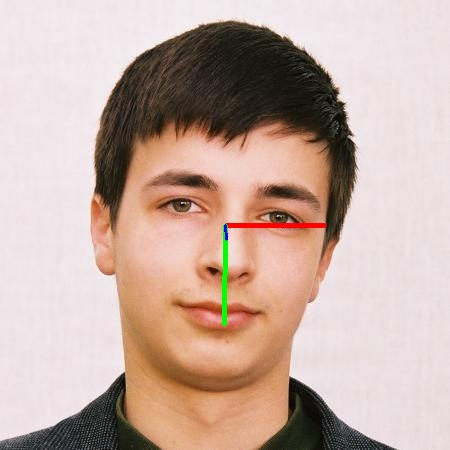

### Testing Function on a Test Image

In [54]:
X_vid = []
Y_vid = []

path = 'dataset\\test\\Mads Mikkelsen.jpg'

faceModule = mediapipe.solutions.face_mesh

with faceModule.FaceMesh(static_image_mode=True) as faces:
            image = cv2.imread(path)
            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
                image_x = []
                image_y = []
                X_vid.append(image_x)
                Y_vid.append(image_y)
                for face in results.multi_face_landmarks:
                    for landmark in face.landmark:
                        x = landmark.x
                        y = landmark.y
                        shape = image.shape 
                        relative_x = int(x * shape[1])
                        relative_y = int(y * shape[0])
                        image_x.append(relative_x)
                        image_y.append(relative_y)
                        cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
            cv2.imshow('', image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

In [55]:
image_x_org = image_x
image_y_org = image_y

In [56]:
image_x = np.array(image_x).reshape(1, 468)
image_x = (image_x - image_x[0][99]) / (np.linalg.norm(image_x[0][400] - image_x[0][200]))

image_y = np.array(image_y).reshape(1, 468)
image_y = (image_y - image_y[0][99]) / (np.linalg.norm(image_y[0][400] - image_y[0][200]))

test = np.concatenate((image_x, image_y), axis=1)

test_angles = pred_angle(test)
pred_pitch = test_angles['pitch']
pred_yaw = test_angles['yaw']
pred_roll = test_angles['roll']

image = cv2.imread('dataset\\test\\Mads Mikkelsen.jpg')
cv2.imwrite('dataset\\test\\mads_axis.jpg', draw_axis(image, pred_pitch, pred_yaw, pred_roll, size=50, tdx=image_x_org[197], tdy=image_y_org[197])) 

cv2.imshow('', draw_axis(image, pred_pitch, pred_yaw, pred_roll, size=50, tdx=image_x_org[197], tdy=image_y_org[197]))
cv2.waitKey(0)
cv2.destroyAllWindows()

### Testing on a Video With Various Head Poses

In [63]:
video_path = 'dataset\test\omar_final.mp4'

filename = 'omar_final_axis.avi'

cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        
        pitch = []
        yaw = []
        roll = []
        
        with faceModule.FaceMesh(static_image_mode=True) as faces:
                    results = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    if results.multi_face_landmarks != None:
                        image_x = []
                        image_y = []
                        for face in results.multi_face_landmarks:
                            for landmark in face.landmark:
                                x = landmark.x
                                y = landmark.y
                                shape = frame.shape 
                                relative_x = int(x * shape[1])
                                relative_y = int(y * shape[0])
                                image_x.append(relative_x)
                                image_y.append(relative_y)
                                
                    image_x_org = image_x
                    image_y_org = image_y
                    
                    image_x = np.array(image_x).reshape(1, 468)
                    image_x = (image_x - image_x[0][99]) / (np.linalg.norm(image_x[0][400] - image_x[0][200]))
                    
                    image_y = np.array(image_y).reshape(1, 468)
                    image_y = (image_y - image_y[0][99]) / (np.linalg.norm(image_y[0][400] - image_y[0][200]))
                    
                    image_features = np.concatenate((image_x, image_y), axis=1)
                    
                    angles = pred_angle(image_features)
                    pred_pitch = angles['pitch']
                    pred_yaw = angles['yaw']
                    pred_roll = angles['roll']
                    
                    pitch.append(pred_pitch)
                    yaw.append(pred_yaw)
                    roll.append(pred_roll)
                    
                    draw_axis(frame, np.mean(np.array(pitch)), np.mean(np.array(yaw)), np.mean(np.array(roll)), size=100, tdx=image_x_org[6], tdy=image_y_org[6])
    
        out.write(frame)
    
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()